In [1]:
import pandas as pd
import numpy as np

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
train_df.dtypes

age                 int64
workclass          object
fnlwgt              int64
education          object
educational-num     int64
marital-status     object
occupation         object
relationship       object
race               object
gender             object
capital-gain        int64
capital-loss        int64
hours-per-week      int64
native-country     object
income_>50K         int64
dtype: object

In [2]:
def convertcat_to_intVar(df):
    # copy dataframe for preliminary decision tree
    df_fi = df
    # Selecting Columns whose values are categorical (in practice, the strings)
    col_categorical = df_fi.select_dtypes(include= ['object']).columns
    # Converting data-type as 'category;
    for col_name in col_categorical:
        df_fi[col_name] = df_fi[col_name].astype('category')
    #Converting categorical entries to integers
    df_fi[col_categorical] = df_fi[col_categorical].apply(lambda x: x.cat.codes)
        
    return df_fi

In [3]:
train_df['train'] = 1
test_df['train'] = 0
combined = pd.concat([train_df, test_df])
df_fi = convertcat_to_intVar(combined)
df_fi.dtypes

c:\programdata\miniconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


age                  int64
capital-gain         int64
capital-loss         int64
education             int8
educational-num      int64
fnlwgt               int64
gender                int8
hours-per-week       int64
income_>50K        float64
marital-status        int8
native-country        int8
occupation            int8
race                  int8
relationship          int8
train                int64
workclass             int8
dtype: object

In [4]:
train_df = df_fi[df_fi['train']==1]
test_df = df_fi[df_fi['train']==0]

In [5]:
train_df.drop('train', axis=1, inplace=True) 
test_df.drop('train', axis=1, inplace=True)

c:\programdata\miniconda3\lib\site-packages\pandas\core\frame.py:3930: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [6]:
X = train_df.loc[:, train_df.columns != 'income_>50K']
y = train_df.loc[:, train_df.columns == 'income_>50K']

In [7]:
test_X = test_df.loc[:, test_df.columns != 'income_>50K']
test_X.head()

,age,capital-gain,capital-loss,education,educational-num,fnlwgt,gender,hours-per-week,marital-status,native-country,occupation,race,relationship,workclass
0,39,0,0,11,9,327120,1,40,2,31,2,4,0,5
1,32,0,0,7,12,123253,1,42,2,38,2,4,0,3
2,47,0,0,11,9,232628,1,40,2,38,2,2,0,3
3,19,0,0,2,8,374262,1,20,4,38,5,4,3,3
4,46,0,0,11,9,311231,1,40,2,38,4,4,0,5


In [10]:
import xgboost as xgb
from sklearn import metrics
from sklearn.model_selection import GridSearchCV 

In [53]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain['income_>50K'].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'],
                          nfold=cv_folds,metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['income_>50K'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain['income_>50K'].values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['income_>50K'], dtrain_predprob))
                    
    feat_imp = pd.Series(float(alg.booster().get_fscore())).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [54]:
predictors = [x for x in train_df.columns if x not in ['income_>50K']]
predictors

['age',
 'capital-gain',
 'capital-loss',
 'education',
 'educational-num',
 'fnlwgt',
 'gender',
 'hours-per-week',
 'marital-status',
 'native-country',
 'occupation',
 'race',
 'relationship',
 'workclass']

Text(0, 0.5, 'Feature Importance Score')

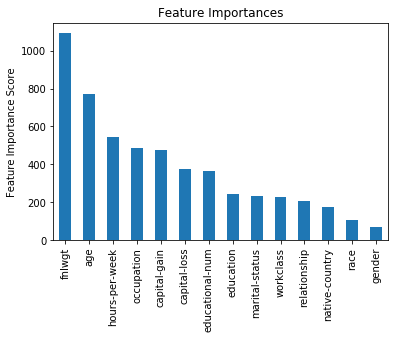

In [60]:
import matplotlib.pyplot as plt
feat_imp = pd.Series(xgb2.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [55]:
#Choose all predictors except target & IDcols
from xgboost.sklearn import XGBClassifier
xgb2 = XGBClassifier(learning_rate =0.1, n_estimators=1000, max_depth=5, min_child_weight=1, gamma=0, subsample=0.8,
                     colsample_bytree=0.8, objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)
modelfit(xgb2, train_df, predictors)


Model Report
Accuracy : 0.8893
AUC Score (Train): 0.945877


TypeError: 'str' object is not callable

In [23]:
##Parameter Tuning
target='income_>50K'
param_test1 = { 'max_depth':list(range(3,10,2)), 'min_child_weight':list(range(1,6,2))}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
                                                  min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                  objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
                        param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train_df[predictors],train_df[target])
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

c:\programdata\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
c:\programdata\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
c:\programdata\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
c:\programdata\miniconda3\lib\site-packages\sklearn\

({'mean_fit_time': array([11.26769557,  9.64739923,  9.70199585, 14.65639858, 13.92139745,
         15.26199799, 19.08179536, 18.16499701, 18.91419802, 29.48741074,
         26.97641063, 23.03648868]),
  'std_fit_time': array([0.92835883, 0.37761575, 0.50833983, 0.46289207, 0.54647807,
         0.67458227, 1.04057853, 0.18355137, 0.8519196 , 1.14798256,
         0.92824043, 3.79317996]),
  'mean_score_time': array([0.05781422, 0.05820465, 0.06820412, 0.05499983, 0.06020322,
         0.11100397, 0.09620428, 0.07920375, 0.07960138, 0.11160393,
         0.09240332, 0.08300261]),
  'std_score_time': array([0.00504472, 0.00778384, 0.01800368, 0.00405051, 0.00466485,
         0.06949874, 0.04044315, 0.0100691 , 0.00926524, 0.01911718,
         0.01349795, 0.00756097]),
  'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
               mask=[False, False, False, False, False, False, False, False,
                     False, False, False, False],
         fill_value='?

In [24]:
param_test2b = {
 'min_child_weight':[6,8,10,12]
}
gsearch2b = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=8,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2b, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2b.fit(train_df[predictors],train_df[target])
gsearch2b.cv_results_, gsearch2b.best_params_, gsearch2b.best_score_

KeyboardInterrupt: 

In [ ]:
param_test2c = {
 'min_child_weight':[6,7]
}
gsearch2c = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=8,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2b, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2c.fit(train_df[predictors],train_df[target])
gsearch2c.cv_results_, gsearch2c.best_params_, gsearch2c.best_score_

In [ ]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=8,
 min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train_df[predictors],train_df[target])
gsearch3.cv_results_, gsearch3.best_params_, gsearch3.best_score_

### Very Important - change the parameters 

In [25]:
##nreplace the best parameters
xgb3 = XGBClassifier(learning_rate =0.1, n_estimators=1000, max_depth=5, min_child_weight=6, gamma=0.1, subsample=0.9,
                     colsample_bytree=0.95,reg_alpha=2, objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)
modelfit(xgb3, train_df, predictors)


Model Report
Accuracy : 0.8872
AUC Score (Train): 0.943657


In [34]:
test_y_pred = xgb3.predict(test_X)
outputY = pd.DataFrame(test_y_pred)
outputY.to_csv('test_pred_XGB3.csv')

In [26]:
from sklearn.preprocessing import StandardScaler
slc= StandardScaler()
X_train_std = slc.fit_transform(X)

c:\programdata\miniconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\programdata\miniconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [47]:
from sklearn.ensemble import RandomForestClassifier
rf_cfl = RandomForestClassifier(n_estimators = 200,
                                max_features = 8, 
                                 min_samples_leaf = 2, 
                                 min_samples_split = 10, 
                                 n_jobs = -1,
                                random_state = 42)

In [48]:
from xgboost.sklearn import XGBClassifier
#xgb1 = XGBClassifier(learning_rate =0.1, n_estimators=1000, max_depth=8, min_child_weight=6, gamma=0.1, subsample=0.95,
                     #colsample_bytree=0.95, reg_alpha=2, objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)
xgb1=XGBClassifier(learning_rate =0.1, n_estimators=1000, max_depth=8, min_child_weight=6, gamma=0.1, subsample=0.9,
                     colsample_bytree=0.95,reg_alpha=2, objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)

In [39]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
xgb3 = XGBClassifier(learning_rate =0.1, n_estimators=1000, max_depth=5, min_child_weight=6, gamma=0.1, subsample=0.9,
                     colsample_bytree=0.95,reg_alpha=2, objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)
tree = DecisionTreeClassifier(criterion='entropy',max_depth=5)
ada = AdaBoostClassifier(base_estimator=tree, n_estimators=500, learning_rate=0.1, random_state=0)

In [49]:
from sklearn.ensemble import VotingClassifier

eclf = VotingClassifier(estimators=[('forest', rf_cfl),('tree', tree), ('xgb3', xgb3), 
                                    ('xgb1', xgb1),('adaboost', ada)], voting='hard')

In [50]:
eclf.fit(X_train_std, y)

c:\programdata\miniconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\programdata\miniconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


VotingClassifier(estimators=[('forest', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=8, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=10,
            min_we...None,
            splitter='best'),
          learning_rate=0.1, n_estimators=500, random_state=0))],
         flatten_transform=None, n_jobs=None, voting='hard', weights=None)

In [51]:
X_test_std = slc.transform(test_X)

c:\programdata\miniconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int8, int64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


In [52]:
y_pred = eclf.predict(X_test_std)
outdf = pd.DataFrame(y_pred)
outdf.to_csv('test_pred_eclf2.csv')